#notebooks.perturbed_grover_state_preparation_1d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from scipy.stats import beta

In [4]:
from utilities.grover_state_preparation import get_grover_angles, state_expansion

In [5]:
def run_algorithm2(data, m=3, num_runs=2, num_shots=1024, nu=0.1):
    """
    Implements Algorithm 2 using utilities from the provided NESYA quantum codebase.

    Args:
        data (array-like): Dataset in [0, 1) to be binned.
        m (int): Number of qubits.
        num_runs (int): Number of Grover feedback iterations.
        num_shots (int): Number of shots per circuit execution.
        nu (float): Scaling factor for feedback angle update.

    Returns:
        list: Results containing (run index, measured_prob, L2 distance)
        np.ndarray: Original target probability distribution.
    """
    backend = Aer.get_backend("qasm_simulator")
    num_bins = 2 ** m
    # Step 1: Bin the data to form target distribution
    bin_edges = np.linspace(0, 1, num_bins + 1)
    hist, _ = np.histogram(data, bins=bin_edges)
    p_target = hist / np.sum(hist)
    # Step 2: Compute Grover angles
    angles = get_grover_angles(p_target, m)
    theta_update = np.ones(len(angles)) * nu
    phi = np.array(angles) + theta_update
    results = []
    for run in range(num_runs):
        # Step 3: Build and run the circuit
        qc = state_expansion(m, phi)
        tqc = transpile(qc, backend)
        counts = backend.run(tqc).result().get_counts()
        # Step 4: Convert counts to empirical probability
        measured_prob = np.zeros(num_bins)
        for bitstring, count in counts.items():
            idx = int(bitstring, 2)
            measured_prob[idx] = count / num_shots
        # Step 5: Compute distance and update phi
        dist = np.linalg.norm(measured_prob - p_target)
        theta_update = np.ones(len(angles)) * nu * dist
        phi += theta_update
        results.append((run + 1, measured_prob.copy(), dist))
        print(f"Run {run + 1}: L2 distance = {dist:.5f}")
        plot_histogram(counts, title=f"Measured Distribution - Run {run + 1}")
        plt.show()
    return results, p_target

In [6]:
alpha = 2
beta_ = 2
m = 3
num_bins = 2 ** m
bin_edges = np.linspace(0, 1, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf_vals = beta.pdf(bin_centers, alpha, beta_)
target_distribution = pdf_vals / np.sum(pdf_vals)
nu_values = np.linspace(0.05, 10, 20)
l2_distances = []

In [7]:
nu_values = np.linspace(0.001, 5, 100)
l2_distances = []
for nu in nu_values:
    results, _ = run_algorithm2(target_distribution, m=m, num_runs=2, num_shots=1000, nu=nu)
    final_generated = results[-1][1]
    distance = np.linalg.norm(final_generated - target_distribution)
    l2_distances.append(distance)

Run 1: L2 distance = 0.02828
Run 2: L2 distance = 0.01703
Run 1: L2 distance = 0.02895
Run 2: L2 distance = 0.04389
Run 1: L2 distance = 0.10163
Run 2: L2 distance = 0.05346
Run 1: L2 distance = 0.10328
Run 2: L2 distance = 0.15818
Run 1: L2 distance = 0.17625
Run 2: L2 distance = 0.16622
Run 1: L2 distance = 0.19034
Run 2: L2 distance = 0.20301
Run 1: L2 distance = 0.22671
Run 2: L2 distance = 0.23629
Run 1: L2 distance = 0.25646
Run 2: L2 distance = 0.27635
Run 1: L2 distance = 0.27270
Run 2: L2 distance = 0.30015
Run 1: L2 distance = 0.31128
Run 2: L2 distance = 0.33930
Run 1: L2 distance = 0.33448
Run 2: L2 distance = 0.42372
Run 1: L2 distance = 0.35137
Run 2: L2 distance = 0.41103
Run 1: L2 distance = 0.39763
Run 2: L2 distance = 0.46626
Run 1: L2 distance = 0.39082
Run 2: L2 distance = 0.48443
Run 1: L2 distance = 0.43287
Run 2: L2 distance = 0.50694
Run 1: L2 distance = 0.42776
Run 2: L2 distance = 0.53124
Run 1: L2 distance = 0.45278
Run 2: L2 distance = 0.53258
Run 1: L2 dist

In [8]:
best_nu = nu_values[np.argmin(l2_distances)]
worst_nu = nu_values[np.argmax(l2_distances)]

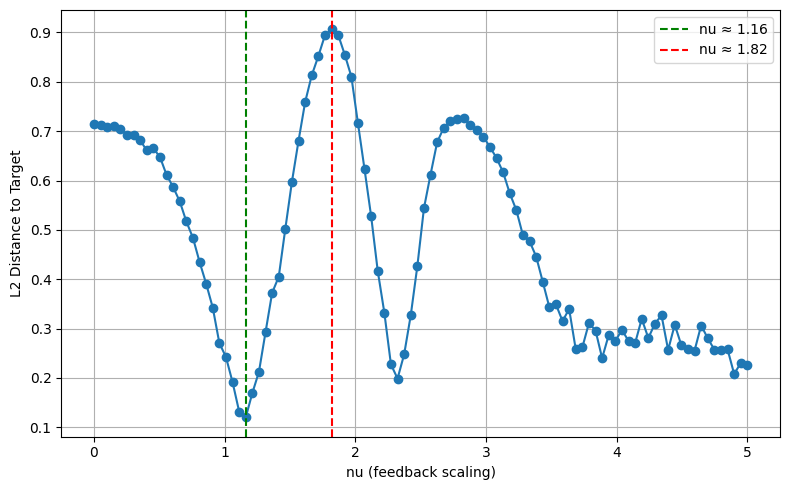

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(nu_values, l2_distances, marker='o')
plt.xlabel("nu (feedback scaling)")
plt.ylabel("L2 Distance to Target")
plt.axvline(best_nu, color='green', linestyle='--', label=f'nu ≈ {best_nu:.2f}')
plt.axvline(worst_nu, color='red', linestyle='--', label=f'nu ≈ {worst_nu:.2f}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
results_best, _ = run_algorithm2(target_distribution, m=m, num_runs=1, num_shots=1000, nu=best_nu)
results_worst, __ = run_algorithm2(target_distribution, m=m, num_runs=1, num_shots=1000, nu=worst_nu)
generated_best = results_best[-1][1]
generated_worst = results_worst[-1][1]

Run 1: L2 distance = 0.54157
Run 1: L2 distance = 0.72353


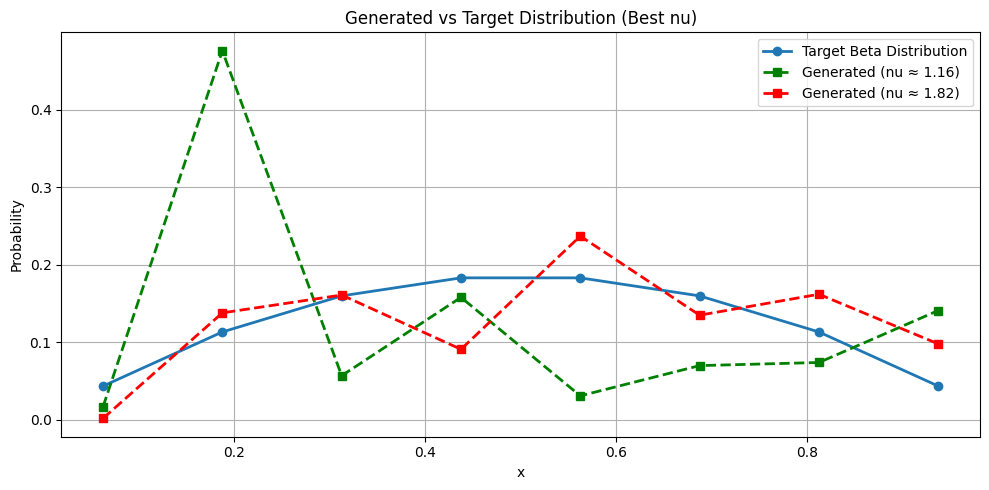

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(bin_centers, target_distribution, 'o-', label='Target Beta Distribution', linewidth=2)
plt.plot(bin_centers, generated_best, 's--', label=f'Generated (nu ≈ {best_nu:.2f})', color='green', linewidth=2)
plt.plot(bin_centers, generated_worst, 's--', label=f'Generated (nu ≈ {worst_nu:.2f})', color='red', linewidth=2)
plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Generated vs Target Distribution (Best nu)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()